# Sentiment analysis on Vietnamese reviews

**Steps:** 
- Clean text: remove emojis, symbols
- Tokenized text using ViTokenizer: word segmentation
- Sentiment scoring using PhoBERT and ViSoBERT model from huggingface

## Sentiment Scoring

Read data (csv file)

In [2]:
import pandas as pd

def read_data(path):
    
    df = pd.read_csv(path)
    df.insert(loc=0, column='id', value=df.index)
    
    return df


Clean data

In [3]:
import re

def preprocess_data(df, col_name):

    reviews = df[col_name]

    pattern = r"[^\w\d.,]"

    transformed_texts = []
    for review in reviews:
        review = review.lower()
        # Split new lines into seperate lines
        lines = review.split("\n")
        modified_lines = []
        for line in lines:
            # Remove colons and leading/trailing whitespaces
            modified_line = line.strip().replace(":", " ")
            modified_line = line.strip().replace("  ", " ")
            modified_line = re.sub(pattern, " ", modified_line)
            modified_line = re.sub(r"(?<=[a-z])(?=[A-Z])", " ", modified_line)
            modified_lines.append(modified_line)
        joined_text = " ".join(modified_lines)  # Join lines with spaces
        transformed_texts.append(joined_text)

    return transformed_texts

Tokenized text using ViTokenized:
- Segment compound words
- Seperate punctuation

In [4]:
from pyvi import ViTokenizer

def tokenize_data(transformed_texts):
    
    tokenized_texts = []

    for text in transformed_texts:
        tokens = ViTokenizer.tokenize(text)
        tokenized_texts.append(tokens)
    
    return tokenized_texts

### Using PhoBERT

This model will return a dataframe of positive, negative, and neutral sentiment score

In [5]:
import torch
from transformers import RobertaForSequenceClassification, AutoTokenizer

def phobert_scoring(tokenized_texts):
    
    model = RobertaForSequenceClassification.from_pretrained(
        "wonrax/phobert-base-vietnamese-sentiment"
    )

    tokenizer = AutoTokenizer.from_pretrained(
        "wonrax/phobert-base-vietnamese-sentiment", use_fast=False
    )

    max_length = 256

    # Tokenization with padding and truncation
    inputs = tokenizer(
        tokenized_texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    phobert_scores = {"id": [], "neg": [], "pos": [], "neu": []}
    for idx, (input_ids_batch, attention_mask_batch) in enumerate(
        zip(input_ids, attention_mask)
    ):
        with torch.no_grad():
            out = model(
                input_ids_batch.unsqueeze(0),
                attention_mask=attention_mask_batch.unsqueeze(0),
            )
            sentiments = out.logits.softmax(dim=-1).tolist()[0]
            phobert_scores["id"].append(idx)
            phobert_scores["neg"].append(sentiments[0])
            phobert_scores["pos"].append(sentiments[1])
            phobert_scores["neu"].append(sentiments[2])

    phobert_scores = pd.DataFrame(phobert_scores)

    return phobert_scores

e:\OneDrive - buv.edu.vn\Desktop\An Khanh\BUV\IJRA\Sentiment Analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Using ViSoBERT

In [6]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig


def visobert_scoring(transformed_texts):

    model_path = "5CD-AI/Vietnamese-Sentiment-visobert"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    config = AutoConfig.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    max_length = 256

    visobert_scores = []

    for id, text in enumerate(transformed_texts):

        inputs = tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
        )

        input_ids = inputs["input_ids"]

        with torch.no_grad():
            out = model(input_ids)
            scores = out.logits.softmax(dim=-1).cpu().numpy()[0]

        # Collect scores
        result = {
            "id": id,
            "neg": scores[config.label2id["NEG"]],
            "pos": scores[config.label2id["POS"]],
            "neu": scores[config.label2id["NEU"]],
        }
        visobert_scores.append(result)

    # Create DataFrame
    df = pd.DataFrame(visobert_scores)

    return df

Calculate the compound score from pos neg neu

In [7]:
def calculate_compound(scores):
    # Using weights: positive=1, neutral=0, negative=-1
    weights = {"neg": -1, "neu": 0, "pos": 1}
    compound_score = (
        weights["neg"] * scores["neg"]
        + weights["neu"] * scores["neu"]
        + weights["pos"] * scores["pos"]
    )
    return compound_score

Convert compound to star rating

In [8]:
def classify_star_rating(compound_score):
    star_rating = []
    
    for score in compound_score:

        if score > 0.6:

            star_rating.append(5)

        elif score > 0.2:
            star_rating.append(4)

        elif score > -0.2:

            star_rating.append(3)

        elif score > -0.6:

            star_rating.append(2)
        else:

            star_rating.append(1)
    
    return star_rating

Merge 2 dataframes

In [9]:
def merge_data(reviews_df, score_df):
    
    df = pd.merge(reviews_df, score_df, how="outer", on=["id"])
    
    return df

## Run on dataset

**Set up**

In [10]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")

In [11]:
raw_data = read_data("data\VN_Reviews_Electronic.csv")

raw_data.head()

<>:1: SyntaxWarning: invalid escape sequence '\V'
<>:1: SyntaxWarning: invalid escape sequence '\V'
C:\Users\admin\AppData\Local\Temp\ipykernel_8508\1760241826.py:1: SyntaxWarning: invalid escape sequence '\V'
  raw_data = read_data("data\VN_Reviews_Electronic.csv")


,id,Product,Reviews,Customer Rating,GPT4o,Gemini 1.5 (Pro),Manual
0,0,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmkhas oon. Khá ổn nhưng chưa...,5,Neutral,Neutral,Neutral
1,1,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmTốt. Tính năng nổi bậtdùng ...,5,Neutral,Positive,Neutral
2,2,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmÂm thanh nghe tốt. Có thể g...,5,Positive,Positive,Positive
3,3,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmokokok. Tính năng nổi bậtha...,5,Positive,Neutral,Positive
4,4,Tai nghe chụp tai không dây bluetooth STN28 mà...,"Giao hàng nhanh, đóng gói cẩn thận, mua acc mớ...",5,Neutral,Neutral,Neutral


**EDA**

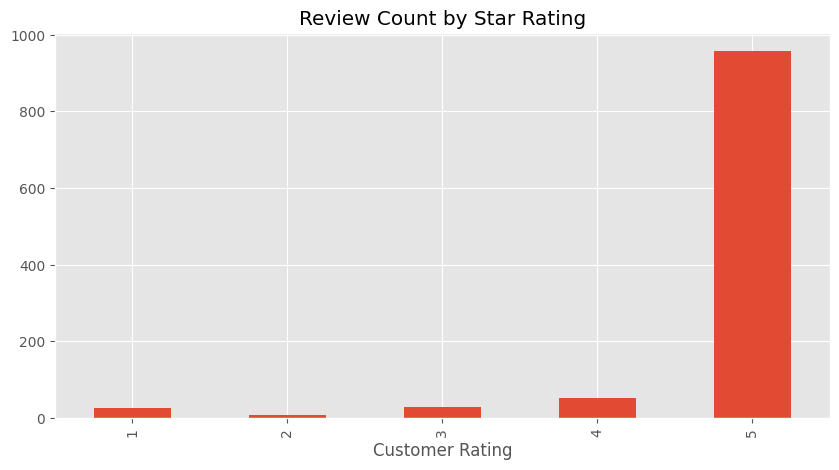

In [12]:
graph = (
raw_data["Customer Rating"]
.value_counts()
.sort_index()
.plot(kind="bar", title="Review Count by Star Rating", figsize=(10, 5))
)

**Pre-processing**

In [13]:
preprocessed_data = preprocess_data(raw_data, 'Reviews')

preprocessed_data[10]

'chất lượng sản phẩmchat luôn. tính năng nổi bậtkhông bt nx tại chx dung. sản phẩm tốt và cảm thấy khá tuyệt khi dùng mọi người nên mua nha'

**Calculate sentiment scores using ViSobert**

In [14]:
visobert_scores = visobert_scoring(preprocessed_data)

visobert_scores.head()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


,id,neg,pos,neu
0,0,0.691226,0.305219,0.003555
1,1,0.062655,0.183715,0.753630
2,2,0.363647,0.635338,0.001015
3,3,0.230504,0.730899,0.038597
4,4,0.218157,0.230088,0.551755


In [15]:
visobert_scores["visobert_comp"] = calculate_compound(visobert_scores)

visobert_scores["visobert_star"] = classify_star_rating(
    visobert_scores["visobert_comp"]
)

In [16]:
visobert_results = merge_data(raw_data, visobert_scores)

visobert_results.rename(columns= {'neg':'visobert_neg', 'pos':'visobert_pos', 'neu':'visobert_neu'}, inplace=True)

visobert_results.head()

,id,Product,Reviews,Customer Rating,GPT4o,Gemini 1.5 (Pro),Manual,visobert_neg,visobert_pos,visobert_neu,visobert_comp,visobert_star
0,0,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmkhas oon. Khá ổn nhưng chưa...,5,Neutral,Neutral,Neutral,0.691226,0.305219,0.003555,-0.386007,2
1,1,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmTốt. Tính năng nổi bậtdùng ...,5,Neutral,Positive,Neutral,0.062655,0.183715,0.753630,0.121060,3
2,2,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmÂm thanh nghe tốt. Có thể g...,5,Positive,Positive,Positive,0.363647,0.635338,0.001015,0.271691,4
3,3,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmokokok. Tính năng nổi bậtha...,5,Positive,Neutral,Positive,0.230504,0.730899,0.038597,0.500395,4
4,4,Tai nghe chụp tai không dây bluetooth STN28 mà...,"Giao hàng nhanh, đóng gói cẩn thận, mua acc mớ...",5,Neutral,Neutral,Neutral,0.218157,0.230088,0.551755,0.011931,3


**Plot ViSoBERT results**

C:\Users\admin\AppData\Local\Temp\ipykernel_8508\2121134484.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


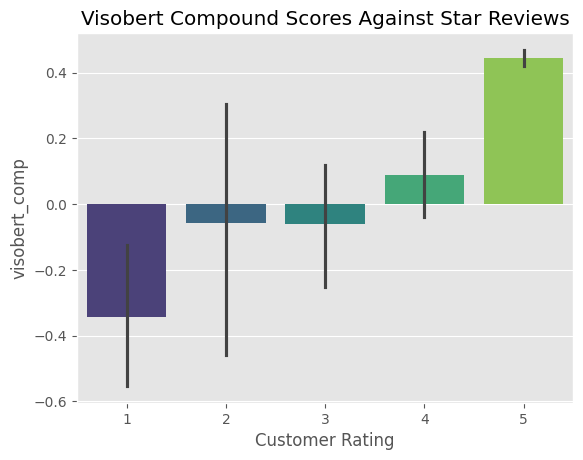

In [17]:
import seaborn as sns

bar = sns.barplot(
    data=visobert_results, x="Customer Rating", y="visobert_comp", palette="viridis"
)
bar.set_title("Visobert Compound Scores Against Star Reviews")
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_8508\3527523652.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\admin\AppData\Local\Temp\ipykernel_8508\3527523652.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\admin\AppData\Local\Temp\ipykernel_8508\3527523652.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


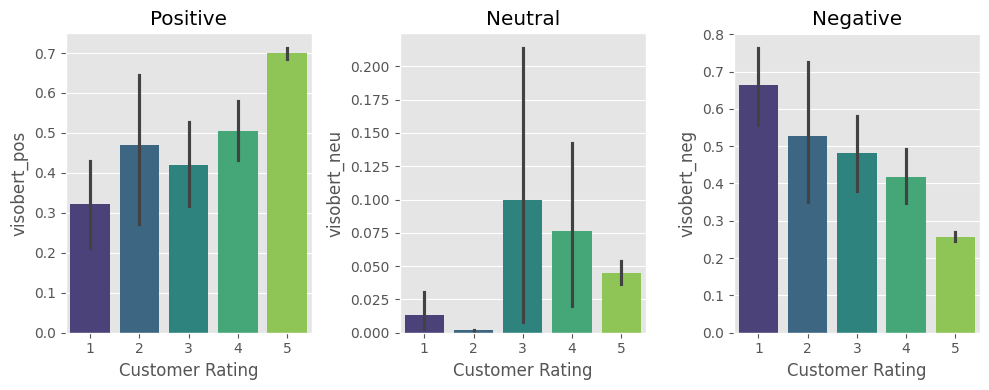

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
sns.barplot(
    data=visobert_results,
    x="Customer Rating",
    y="visobert_pos",
    ax=axs[0],
    palette="viridis",
)
sns.barplot(
    data=visobert_results,
    x="Customer Rating",
    y="visobert_neu",
    ax=axs[1],
    palette="viridis",
)
sns.barplot(
    data=visobert_results,
    x="Customer Rating",
    y="visobert_neg",
    ax=axs[2],
    palette="viridis",
)

axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

**Calculate sentiment score using PhoBERT**

In [19]:
tokenized_data = tokenize_data(preprocessed_data)

tokenized_data[0]

'chất_lượng sản phẩmkhas oon . khá ổn nhưng chưa biết pin được bao_lâu'

In [20]:
phobert_scores = phobert_scoring(tokenized_data)

phobert_scores['phobert_comp'] = calculate_compound(phobert_scores)

phobert_scores["phobert_star"] = classify_star_rating(phobert_scores["phobert_comp"])

phobert_scores.head()

,id,neg,pos,neu,phobert_comp,phobert_star
0,0,0.004904,0.935544,0.059552,0.930640,5
1,1,0.018084,0.832600,0.149316,0.814516,5
2,2,0.002161,0.988667,0.009172,0.986507,5
3,3,0.006940,0.935988,0.057072,0.929047,5
4,4,0.004038,0.979416,0.016545,0.975378,5


In [21]:
phobert_results = merge_data(raw_data, phobert_scores)

phobert_results.rename(
    columns={"neg": "phobert_neg", "pos": "phobert_pos", "neu": "phobert_neu"},
    inplace=True,
)

phobert_results.head()

,id,Product,Reviews,Customer Rating,GPT4o,Gemini 1.5 (Pro),Manual,phobert_neg,phobert_pos,phobert_neu,phobert_comp,phobert_star
0,0,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmkhas oon. Khá ổn nhưng chưa...,5,Neutral,Neutral,Neutral,0.004904,0.935544,0.059552,0.930640,5
1,1,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmTốt. Tính năng nổi bậtdùng ...,5,Neutral,Positive,Neutral,0.018084,0.832600,0.149316,0.814516,5
2,2,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmÂm thanh nghe tốt. Có thể g...,5,Positive,Positive,Positive,0.002161,0.988667,0.009172,0.986507,5
3,3,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmokokok. Tính năng nổi bậtha...,5,Positive,Neutral,Positive,0.006940,0.935988,0.057072,0.929047,5
4,4,Tai nghe chụp tai không dây bluetooth STN28 mà...,"Giao hàng nhanh, đóng gói cẩn thận, mua acc mớ...",5,Neutral,Neutral,Neutral,0.004038,0.979416,0.016545,0.975378,5


**Plot PhoBERT results**

C:\Users\admin\AppData\Local\Temp\ipykernel_8508\1234777147.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar = sns.barplot(


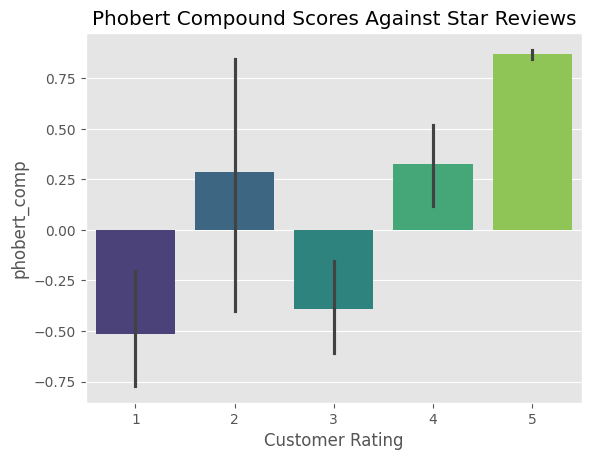

In [22]:
import seaborn as sns

bar = sns.barplot(
    data=phobert_results, x="Customer Rating", y="phobert_comp", palette="viridis"
)
bar.set_title("Phobert Compound Scores Against Star Reviews")
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_8508\1262230075.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\admin\AppData\Local\Temp\ipykernel_8508\1262230075.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\admin\AppData\Local\Temp\ipykernel_8508\1262230075.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


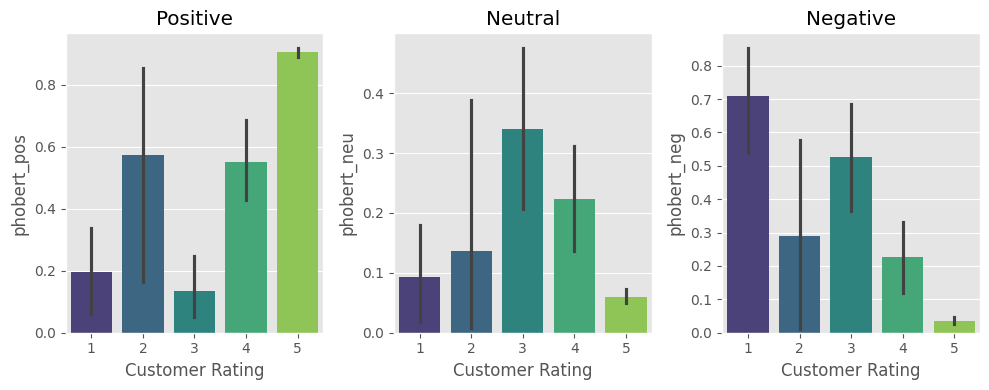

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
sns.barplot(
    data=phobert_results,
    x="Customer Rating",
    y="phobert_pos",
    ax=axs[0],
    palette="viridis",
)
sns.barplot(
    data=phobert_results,
    x="Customer Rating",
    y="phobert_neu",
    ax=axs[1],
    palette="viridis",
)
sns.barplot(
    data=phobert_results,
    x="Customer Rating",
    y="phobert_neg",
    ax=axs[2],
    palette="viridis",
)

axs[0].set_title("Positive")
axs[1].set_title("Neutral")
axs[2].set_title("Negative")
plt.tight_layout()
plt.show()

### Compare results from different methods

In [24]:
results_df = pd.merge(phobert_results, visobert_results)
results_df.head()

,id,Product,Reviews,Customer Rating,GPT4o,Gemini 1.5 (Pro),Manual,phobert_neg,phobert_pos,phobert_neu,phobert_comp,phobert_star,visobert_neg,visobert_pos,visobert_neu,visobert_comp,visobert_star
0,0,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmkhas oon. Khá ổn nhưng chưa...,5,Neutral,Neutral,Neutral,0.004904,0.935544,0.059552,0.930640,5,0.691226,0.305219,0.003555,-0.386007,2
1,1,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmTốt. Tính năng nổi bậtdùng ...,5,Neutral,Positive,Neutral,0.018084,0.832600,0.149316,0.814516,5,0.062655,0.183715,0.753630,0.121060,3
2,2,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmÂm thanh nghe tốt. Có thể g...,5,Positive,Positive,Positive,0.002161,0.988667,0.009172,0.986507,5,0.363647,0.635338,0.001015,0.271691,4
3,3,Tai nghe chụp tai không dây bluetooth STN28 mà...,Chất lượng sản phẩmokokok. Tính năng nổi bậtha...,5,Positive,Neutral,Positive,0.006940,0.935988,0.057072,0.929047,5,0.230504,0.730899,0.038597,0.500395,4
4,4,Tai nghe chụp tai không dây bluetooth STN28 mà...,"Giao hàng nhanh, đóng gói cẩn thận, mua acc mớ...",5,Neutral,Neutral,Neutral,0.004038,0.979416,0.016545,0.975378,5,0.218157,0.230088,0.551755,0.011931,3


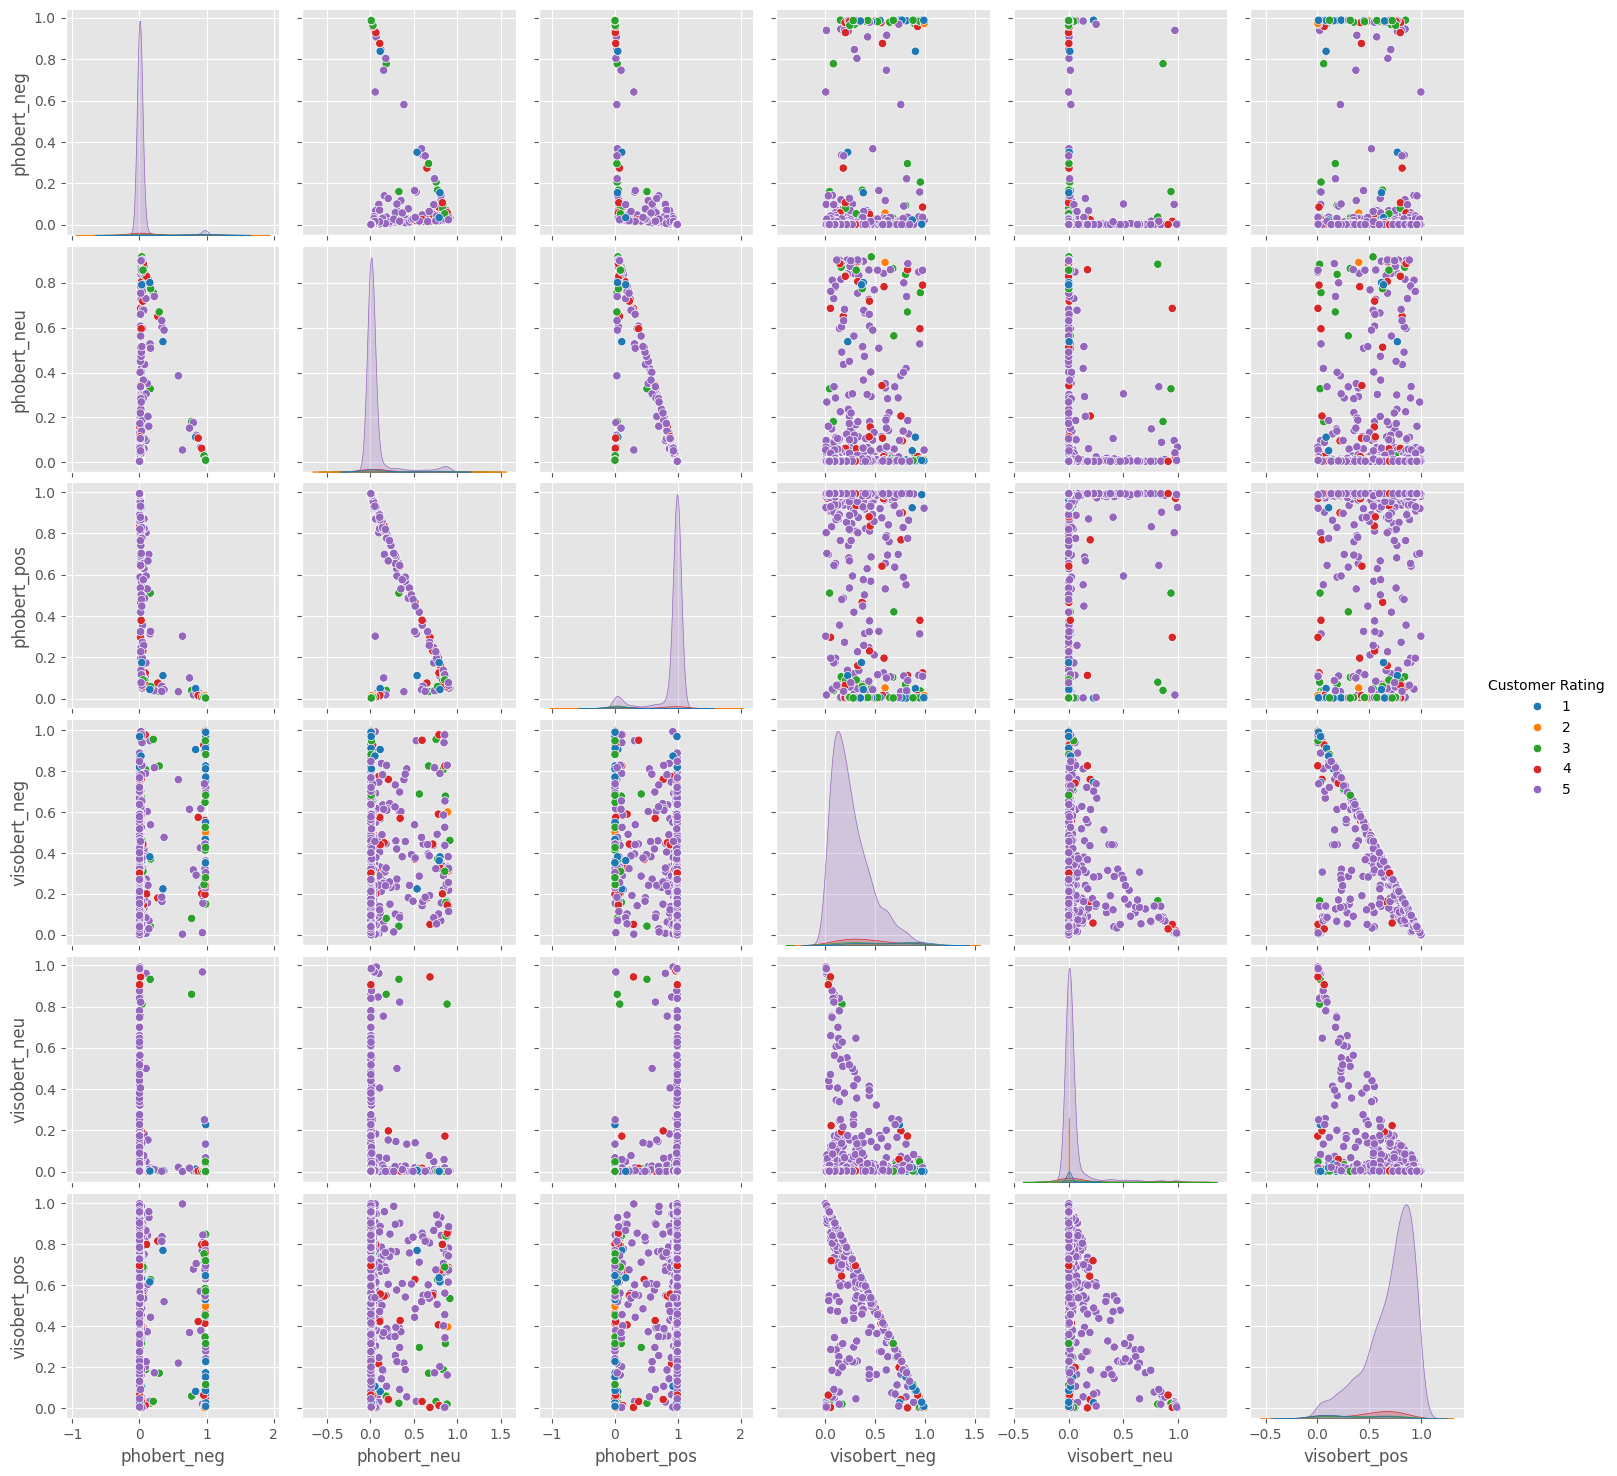

In [25]:
sns.pairplot(
    data=results_df,
    vars=[
        "phobert_neg",
        "phobert_neu",
        "phobert_pos",
        "visobert_neg",
        "visobert_neu",
        "visobert_pos",
    ],
    hue="Customer Rating",
    palette="tab10",
)
plt.show()

In [34]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

def star_to_annotation(compound):
    if compound > 0.4:
        return "Positive"
    elif compound < -0.4:
        return "Negative"
    else:
        return "Neutral"

results_df["PhoBERT"] = results_df['phobert_comp'].apply(star_to_annotation)
results_df["ViSoBERT"] = results_df["visobert_comp"].apply(star_to_annotation)

# Calculate metrics for each model
models = ["PhoBERT", "ViSoBERT", "GPT4o", "Gemini 1.5 (Pro)"]

metrics = {
    "model": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
}

for model in models:
    y_true = results_df["Manual"]
    y_pred = results_df[model]

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    metrics["model"].append(model)
    metrics["accuracy"].append(accuracy)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1_score"].append(f1)

metrics_df = pd.DataFrame(metrics)

metrics_df

e:\OneDrive - buv.edu.vn\Desktop\An Khanh\BUV\IJRA\Sentiment Analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\OneDrive - buv.edu.vn\Desktop\An Khanh\BUV\IJRA\Sentiment Analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\OneDrive - buv.edu.vn\Desktop\An Khanh\BUV\IJRA\Sentiment Analysis\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` para

,model,accuracy,precision,recall,f1_score
0,PhoBERT,0.449533,0.258827,0.449533,0.324882
1,ViSoBERT,0.382243,0.276228,0.382243,0.314167
2,GPT4o,0.536449,0.758695,0.536449,0.486369
3,Gemini 1.5 (Pro),0.636449,0.710563,0.636449,0.638492


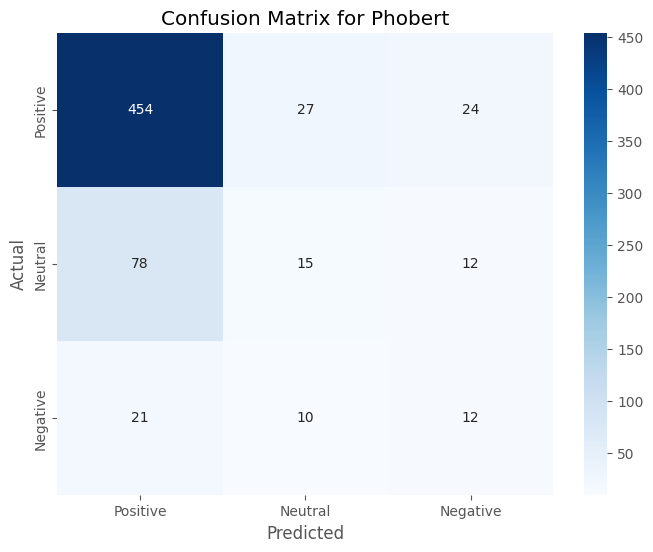

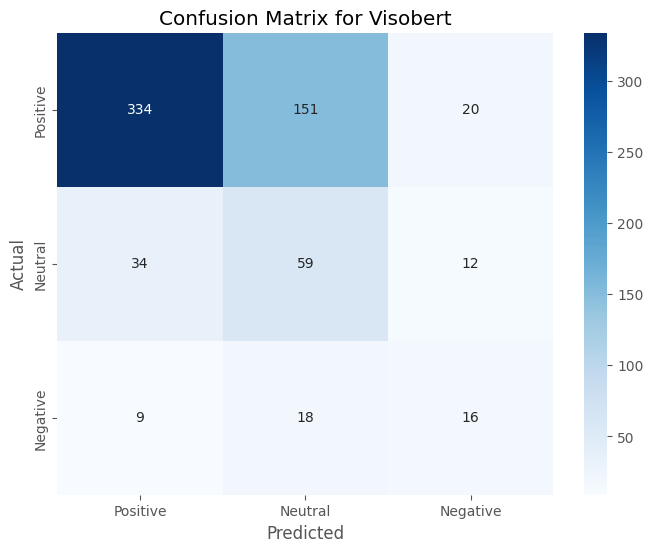

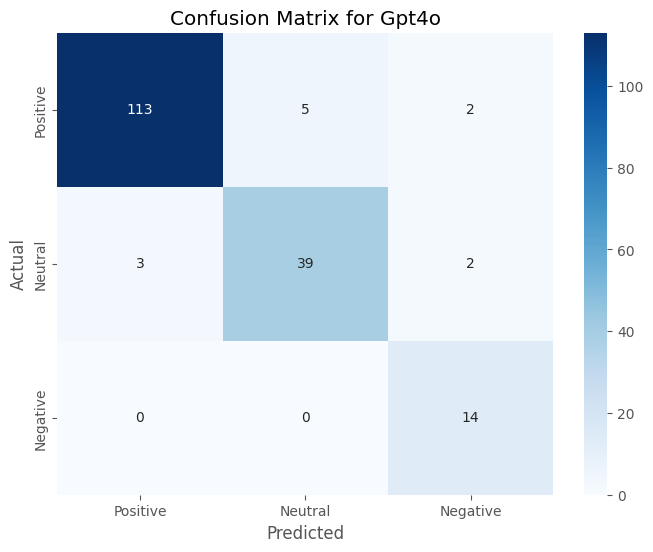

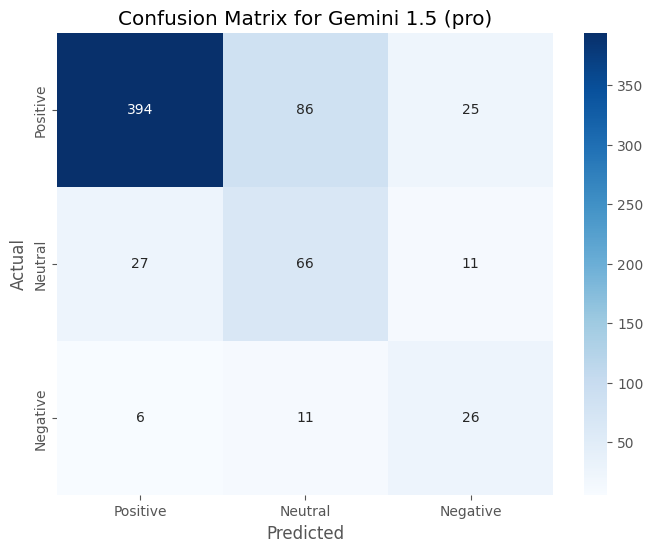

In [35]:
from sklearn.metrics import confusion_matrix

for model in models:
    y_true = results_df["Manual"]
    y_pred = results_df[model]

    cm = confusion_matrix(y_true, y_pred, labels=["Positive", "Neutral", "Negative"])
    cm_df = pd.DataFrame(
        cm,
        index=["Positive", "Neutral", "Negative"],
        columns=["Positive", "Neutral", "Negative"],
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model.capitalize()}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()